# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 1: wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

C:\Users\keving\AppData\Local\Temp\ipykernel_24212\649372525.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
C:\Users\keving\AppData\Local\Temp\ipykernel_24212\649372525.py:14: SettingWithCopyW

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [12]:
# global parameter
numepochs = 500

def trainTheModel(useXavier):

  winenet = ANNwine()

  # change the weights (leave biases as Kaiming [default])
  if(useXavier):
    for p in winenet.named_parameters():
      if 'weight' in p[0]:
        nn.init.xavier_normal_(p[1].data)

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses,winenet

# Now to create the fitted model

In [16]:
# create and train a model

numExps = 10


# dimensions of results:
#  1 - experiment run
#  2 - metric (loss/train/test)
#  3 - weight init (K/X)
results = np.zeros( (numExps,3,2) )


for i in range(10):
  trainAcc,testAcc,losses,net = trainTheModel(False) # kaiming
  results[i, 0, 0] = torch.mean(losses[-5:]).item()
  results[i, 1, 0] = np.mean(trainAcc[-5:])
  results[i, 2, 0] = np.mean(trainAcc[-5:])  

  trainAcc,testAcc,losses,net = trainTheModel(True) # xavier  
  results[i, 0, 1] = torch.mean(losses[-5:]).item()
  results[i, 1, 1] = np.mean(trainAcc[-5:])
  results[i, 2, 1] = np.mean(trainAcc[-5:])  



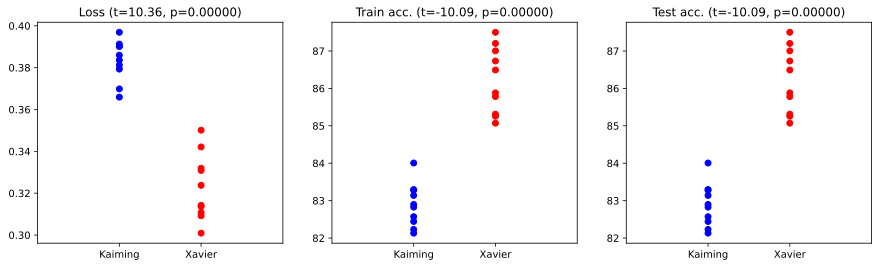

In [18]:
# And plot the results
fig,ax = plt.subplots(1,3,figsize=(15,4))

# plot titles
metric = ['Loss','Train acc.','Test acc.']

for i in range(3):
  
  # plot the results
  ax[i].plot(np.zeros(numExps),results[:,i,0],'bo')
  ax[i].plot(np.ones(numExps),results[:,i,1],'ro')
  
  # run a t-test to formalize the comparison
  t,p = stats.ttest_ind(results[:,i,0],results[:,i,1])
  title = '%s (t=%.2f, p=%.5f)' %(metric[i],t,p)

  
  # make the plot look a bit nicer
  ax[i].set_xlim([-1,2])
  ax[i].set_xticks([0,1])
  ax[i].set_xticklabels(['Kaiming','Xavier'])
  ax[i].set_title(title)

plt.show()